## 01c POI Data - Preprocessing

In [1]:
#Imports
import osmnx as ox
import folium
import geopandas as gp

from shapely.geometry import Point, Polygon
from h3 import h3 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# POIs in OSM are called amenities
amenity_pois = ox.features_from_place({'city': 'Chicago'}, {'amenity': True})
amenity_pois.head(3)

amenity ferry  \
element_type osmid                             
node         20217109   ferry_terminal   yes   
             20217442   ferry_terminal   yes   
             258490031         parking   NaN   

                                                                     name  \
element_type osmid                                                          
node         20217109                               Shoreline Sightseeing   
             20217442   Union Station/Willis Tower - Shoreline Water T...   
             258490031                                                NaN   

                                     network              operator  \
element_type osmid                                                   
node         20217109   Shoreline Water Taxi  Shoreline Water Taxi   
             20217442   Shoreline Water Taxi  Shoreline Water Taxi   
             258490031                   NaN                   NaN   

                       public_transport source                    geometry  \
element_type osmid                                                           
node         20217109           station    PGS  POINT (-87.62252 41.88914)   
             20217442           station    NaN  POINT (-87.63774 41.87906)   
             258490031              NaN    NaN  POINT (-87.64385 41.95123)   

                       highway access  ... building:floor residential  \
element_type osmid                     ...                              
node         20217109      NaN    NaN  ...            NaN         NaN   
             20217442      NaN    NaN  ...            NaN         NaN   
             258490031     NaN    NaN  ...            NaN         NaN   

                       marketplace ways name:fa name:fr name:tl not:name  \
element_type osmid                                                         
node         20217109          NaN  NaN     NaN     NaN     NaN      NaN   
             20217442          NaN  NaN     NaN     NaN     NaN      NaN   
             258490031         NaN  NaN     NaN     NaN     NaN      NaN   

                       industrial diet:dairy_free  
element_type osmid                                 
node         20217109         NaN             NaN  
             20217442         NaN             NaN  
             258490031        NaN             NaN  

[3 rows x 519 columns]

In [3]:
# Next to amenities is an extra section for public transport, we could also use this in addition:
# https://wiki.openstreetmap.org/wiki/Map_features#Addresses
transport_pois = ox.features_from_place({'city': 'Chicago'}, {'public_transport': True})

In [4]:
# Pick fields of interest, drop unnecessary column "element_type" and reset index
amenity_pois = amenity_pois[["amenity", "name", "geometry", "public_transport"]].reset_index().set_index("osmid").drop("element_type", axis=1)
amenity_pois.head(3)

,amenity,name,geometry,public_transport
osmid,,,,
20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.62252 41.88914),station
20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.63774 41.87906),station
258490031,parking,NaN,POINT (-87.64385 41.95123),NaN


In [5]:
# To geodf, check if right CRS for lat/lon later
amenity_gdf = gp.GeoDataFrame(amenity_pois)
# amenity_gdf = amenity_gdf.to_crs(4326)
print(amenity_gdf.crs)

epsg:4326


In [6]:
# Count how many unique entries there are, get overview
print(f"Unique amenities in Chicago: {len(amenity_gdf['amenity'].unique())}")

amenity_counts = amenity_gdf['amenity'].value_counts()
print("Amenities in Chicago and their count:")
for amenity, count in amenity_counts.items():
    print(f"{amenity}: {count}")

Unique amenities in Chicago: 126
Amenities in Chicago and their count:
parking: 7025
parking_space: 4970
restaurant: 2236
place_of_worship: 1861
fast_food: 1330
school: 1185
bicycle_parking: 1116
bench: 960
bicycle_rental: 888
bar: 844
cafe: 768
bank: 457
fuel: 421
parking_entrance: 409
shelter: 279
post_box: 275
loading_dock: 248
toilets: 235
fountain: 213
social_facility: 211
drinking_water: 190
pharmacy: 177
clinic: 170
waste_basket: 167
vending_machine: 115
ice_cream: 115
library: 107
atm: 105
fire_station: 103
dentist: 101
post_office: 97
pub: 97
studio: 94
theatre: 87
car_wash: 70
community_centre: 61
charging_station: 59
university: 52
childcare: 46
ferry_terminal: 45
doctors: 45
hospital: 40
arts_centre: 38
police: 38
veterinary: 37
events_venue: 36
social_centre: 35
money_transfer: 31
recycling: 30
college: 28
kindergarten: 26
cinema: 24
car_rental: 23
bus_station: 22
nightclub: 20
post_depot: 20
bicycle_repair_station: 20
public_bookcase: 18
bureau_de_change: 18
animal_shelte

In [7]:
# Add lat and lon for each entry (eometry column can also be a multipolygon)
amenity_gdf["latitude"] = amenity_gdf.geometry.apply(lambda row: row.y if isinstance(row, Point) else row.centroid.y)
amenity_gdf["longitude"] = amenity_gdf.geometry.apply(lambda row: row.x if isinstance(row, Point) else row.centroid.x)

In [8]:
# Add the count for each amenity type as column
## TODO: drop duplicates? (different names/ids) - maybe group similar amenities?
amenity_gdf["count"] = amenity_gdf.groupby("amenity")['name'].transform('count')
amenity_gdf.head()

,amenity,name,geometry,public_transport,latitude,longitude,count
osmid,,,,,,,
20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.62252 41.88914),station,41.889145,-87.622517,45
20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.63774 41.87906),station,41.879062,-87.637740,45
258490031,parking,NaN,POINT (-87.64385 41.95123),NaN,41.951227,-87.643847,272
269449042,parking_entrance,NaN,POINT (-87.61506 41.85869),NaN,41.858689,-87.615058,6
269450074,parking_entrance,NaN,POINT (-87.58421 41.79174),NaN,41.791742,-87.584208,6


In [9]:
# Get hex ids
def hex_ids(df, res):
    df[f"h3_res{res}"] = df.apply(
        lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], res), axis=1)
    return amenity_gdf

# Get poly from hex ids
def poly_from_hex(df, res):
    df[f"poly_res{res}"] = df.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[f"h3_res{res}"], geo_json=True)), axis=1)
    return df

In [13]:
hex_df = hex_ids(amenity_gdf, 6)
hex_df = hex_ids(amenity_gdf, 7)
hex_df = hex_ids(amenity_gdf, 8)
hex_df = hex_ids(amenity_gdf, 9)

hex_df = poly_from_hex(hex_df, 6)
hex_df = poly_from_hex(hex_df, 7)
hex_df = poly_from_hex(hex_df, 8)
hex_df = poly_from_hex(hex_df, 9)

hex_df.head()

,amenity,name,geometry,public_transport,latitude,longitude,count,h3_res7,h3_res8,h3_res9,poly_res7,poly_res8,poly_res9,h3_res6,poly_res6
osmid,,,,,,,,,,,,,,,
20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.62252 41.88914),station,41.889145,-87.622517,45,872664c1effffff,882664c1e3fffff,892664c1e23ffff,"POLYGON ((-87.63049 41.90755, -87.64322 41.899...","POLYGON ((-87.62100 41.89255, -87.62704 41.890...","POLYGON ((-87.62224 41.88964, -87.62405 41.888...",862664c1fffffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899..."
20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.63774 41.87906),station,41.879062,-87.637740,45,872664c1affffff,882664c1adfffff,892664c1ac7ffff,"POLYGON ((-87.63912 41.88714, -87.65185 41.878...","POLYGON ((-87.63912 41.88714, -87.64516 41.885...","POLYGON ((-87.63737 41.88193, -87.63919 41.880...",862664c1fffffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899..."
258490031,parking,NaN,POINT (-87.64385 41.95123),NaN,41.951227,-87.643847,272,872664c14ffffff,882664c145fffff,892664c144fffff,"POLYGON ((-87.63414 41.96445, -87.64689 41.956...","POLYGON ((-87.64084 41.95799, -87.64689 41.956...","POLYGON ((-87.64331 41.95215, -87.64513 41.950...",862664c17ffffff,"POLYGON ((-87.63414 41.96445, -87.67648 41.951..."
269449042,parking_entrance,NaN,POINT (-87.61506 41.85869),NaN,41.858689,-87.615058,6,872664c1bffffff,882664c1b1fffff,892664c1b03ffff,"POLYGON ((-87.61821 41.87110, -87.63093 41.862...","POLYGON ((-87.61347 41.86360, -87.61951 41.861...","POLYGON ((-87.61470 41.86069, -87.61652 41.859...",862664c1fffffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899..."
269450074,parking_entrance,NaN,POINT (-87.58421 41.79174),NaN,41.791742,-87.584208,6,872664cc5ffffff,882664cc59fffff,892664cc583ffff,"POLYGON ((-87.59371 41.79823, -87.60642 41.789...","POLYGON ((-87.58230 41.79718, -87.58833 41.795...","POLYGON ((-87.58353 41.79427, -87.58535 41.793...",862664cc7ffffff,"POLYGON ((-87.61458 41.81426, -87.65679 41.801..."


In [14]:
def make_geodfs(res):
    return gp.GeoDataFrame(hex_df, geometry=hex_df[f'poly_res{res}'], crs='EPSG:4326')

gdf_res6 = make_geodfs(6)
gdf_res7 = make_geodfs(7)
gdf_res8 = make_geodfs(8)
gdf_res9 = make_geodfs(9)
gdf_res8.head()

,amenity,name,geometry,public_transport,latitude,longitude,count,h3_res7,h3_res8,h3_res9,poly_res7,poly_res8,poly_res9,h3_res6,poly_res6
osmid,,,,,,,,,,,,,,,
20217109,ferry_terminal,Shoreline Sightseeing,"POLYGON ((-87.62100 41.89255, -87.62704 41.890...",station,41.889145,-87.622517,45,872664c1effffff,882664c1e3fffff,892664c1e23ffff,"POLYGON ((-87.63049 41.90755, -87.64322 41.899...","POLYGON ((-87.62100 41.89255, -87.62704 41.890...","POLYGON ((-87.62224 41.88964, -87.62405 41.888...",862664c1fffffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899..."
20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,"POLYGON ((-87.63912 41.88714, -87.64516 41.885...",station,41.879062,-87.637740,45,872664c1affffff,882664c1adfffff,892664c1ac7ffff,"POLYGON ((-87.63912 41.88714, -87.65185 41.878...","POLYGON ((-87.63912 41.88714, -87.64516 41.885...","POLYGON ((-87.63737 41.88193, -87.63919 41.880...",862664c1fffffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899..."
258490031,parking,NaN,"POLYGON ((-87.64084 41.95799, -87.64689 41.956...",NaN,41.951227,-87.643847,272,872664c14ffffff,882664c145fffff,892664c144fffff,"POLYGON ((-87.63414 41.96445, -87.64689 41.956...","POLYGON ((-87.64084 41.95799, -87.64689 41.956...","POLYGON ((-87.64331 41.95215, -87.64513 41.950...",862664c17ffffff,"POLYGON ((-87.63414 41.96445, -87.67648 41.951..."
269449042,parking_entrance,NaN,"POLYGON ((-87.61347 41.86360, -87.61951 41.861...",NaN,41.858689,-87.615058,6,872664c1bffffff,882664c1b1fffff,892664c1b03ffff,"POLYGON ((-87.61821 41.87110, -87.63093 41.862...","POLYGON ((-87.61347 41.86360, -87.61951 41.861...","POLYGON ((-87.61470 41.86069, -87.61652 41.859...",862664c1fffffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899..."
269450074,parking_entrance,NaN,"POLYGON ((-87.58230 41.79718, -87.58833 41.795...",NaN,41.791742,-87.584208,6,872664cc5ffffff,882664cc59fffff,892664cc583ffff,"POLYGON ((-87.59371 41.79823, -87.60642 41.789...","POLYGON ((-87.58230 41.79718, -87.58833 41.795...","POLYGON ((-87.58353 41.79427, -87.58535 41.793...",862664cc7ffffff,"POLYGON ((-87.61458 41.81426, -87.65679 41.801..."


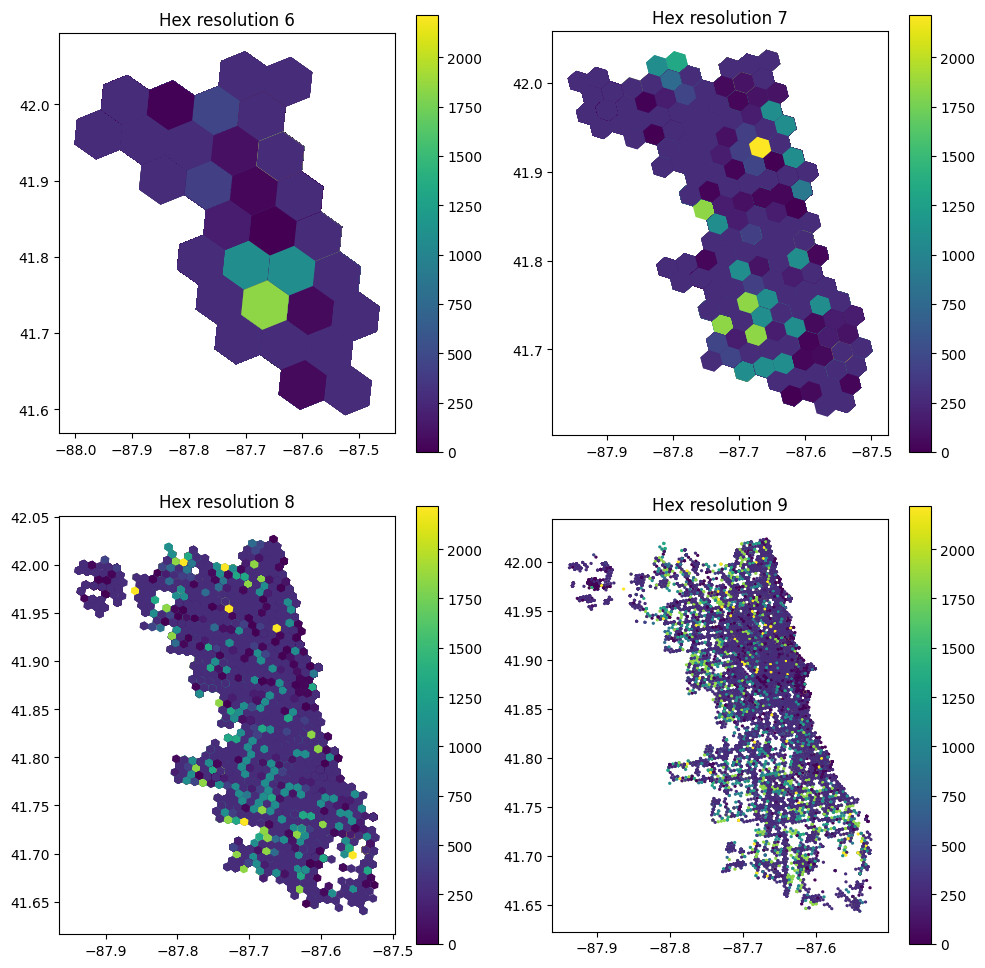

In [18]:
#Visualize the amenities with different hex resolutions, TODO: decide which fits best/compare with taxidata
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10))
dfs = [gdf_res6, gdf_res7 , gdf_res8, gdf_res9]

titles = ["Hex resolution 6", "Hex resolution 7", "Hex resolution 8", "Hex resolution 9"]

axs = axs.flatten()
for ind in range(0, 4):
    dfs[ind].plot(column="count", ax=axs[ind], legend=True)
    axs[ind].set_title(titles[ind])

plt.tight_layout()
plt.show()